# TODO:

*  Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* action repeat Wrapper (4 Times)
* better reward handling for different games
* Explanations
* Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
!nvidia-smi

Mon Mar 29 06:28:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:09:00.0 Off |                  N/A |
| 23%   28C    P8     8W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [3]:
# Hier kann das Spiel übergeben werden
game = "Breakout-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [4]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [5]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [6]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [7]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [8]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [9]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [10]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

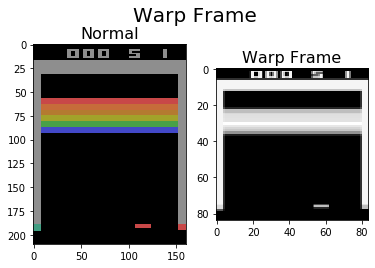

In [11]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [12]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

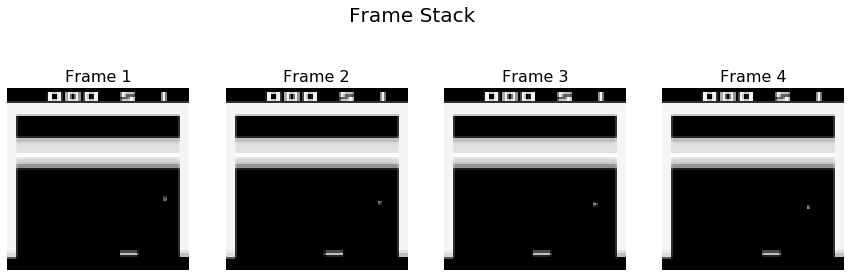

In [13]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
    axs[i].axis("off")
plt.show()

### Erstellen des Environments

In [31]:
def make_env(env_name):
    env = gym.make(env_name)
    #env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    #env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)


""" saving the properties for csv """
MODE = "NoEpisodicLife_NoClipReward_PRETRAINED_w_EpisodicLife"
PATH = "WEIGHTS/" + game + "/" + MODE + "/"
print(PATH)

WEIGHTS/Breakout-v0/NoEpisodicLife_NoClipReward_PRETRAINED_w_EpisodicLife/


# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [15]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop, Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = "mean_squared_error" # Huber
OPTIMIZER = Adam(lr=0.00005)#RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01)

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)
    net_output = Dense(OUTPUT_SHAPE)(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [16]:
#DQN.summary()
#TARGET.summary()

# **Memory Buffer**

In [17]:
MEMORY_SIZE = 25000#1000000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 32#50000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
    MEMORY_BUFFER.append([state, action, reward, next_state, done])

# **Experience Replay**

In [18]:
import random
MINIBATCH_SIZE = 32
GAMMA = 0.99

def replay():

    # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
    minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.concatenate(states)
    next_states = np.concatenate(next_states)

    q_values = DQN.predict(states)
    q_values_next = TARGET.predict(next_states)

    # Q-Values Update
    for i in range(MINIBATCH_SIZE):
        a = actions[i]
        done = dones[i]
        if done:
            q_values[i][a] = rewards[i]
        else:
            q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

    DQN.fit(states, q_values, batch_size=MINIBATCH_SIZE, verbose=0)

# **Aktion wählen**
Exploration & Exploitation

In [19]:
def linear(epsilon, decay, epsilon_min, decay_step):
    return epsilon - decay

def exponential(epsilon, decay, epsilon_min, decay_step):
    epsilon = 1
    return epsilon_min + (epsilon - epsilon_min) * np.exp(-decay * decay_step)

def epsilon_decay(mode, epsilon, decay, epsilon_min, decay_step):
    decay_strategy = {
        "linear": linear,
        "exponential": exponential
    }
    strategy = decay_strategy.get(mode)
    return strategy(epsilon, decay, epsilon_min, decay_step)

Aktion auf Basis der Explorationsstrategie wählen

In [34]:
EPSILON = 0.1#1.0
EPSILON_MIN = 0.1
#EPSILON_STEPS = 1000000
EPSILON_DECAY = 0.00002 #0.0000009

def get_action(state):
    if np.random.rand() <= EPSILON:
        return np.random.randint(env.action_space.n)
    else:
        return np.argmax(DQN(state))

In [21]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

0.0

# **Training des Agenten**

In [35]:
EPISODES = 5000#15000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
EPSILON_LIST = []
STEPS = 0
SYNC = 1000 #10000

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im MEMORY BUFFER speichern
        save_transition(state, action, reward, next_state, done)
        
        # Experience Replay, falls genügend Transitionen gespeichert
        if len(MEMORY_BUFFER) > TRAIN_START:
            replay()
            
        # Synchronisation zwischen Target Networks und Deep Q-Network (alle 1000 Updates - Algorithm 1)
        if STEPS % SYNC == 0:
            TARGET.set_weights(DQN.get_weights())

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # State aktualisieren
        state = next_state
        STEPS += 1
        
        # EPSILON verringern
        if EPSILON > EPSILON_MIN:
            EPSILON = epsilon_decay("exponential", EPSILON, EPSILON_DECAY, EPSILON_MIN, STEPS)

        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            EPSILON_LIST.append(EPSILON)
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD, "\tTRAIN START:", (len(MEMORY_BUFFER)>TRAIN_START), "\tEpsi:", EPSILON)

            # Übernahme des höchsteb Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # Trainierte Gewichte speichern
                if EPSILON < 0.3:
                    import os
                    try:
                        os.makedirs(PATH)
                    except FileExistsError:
                        # Pfad existiert bereits
                        pass
                    DQN.save_weights(PATH +"Best.h5")

Episode: 1 	Reward: 8.0 	Mean: 8.0 	BestMean: 0.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2 	Reward: 13.0 	Mean: 10.5 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3 	Reward: 7.0 	Mean: 9.33 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1
Episode: 4 	Reward: 7.0 	Mean: 8.75 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1
Episode: 5 	Reward: 15.0 	Mean: 10.0 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1
Episode: 6 	Reward: 9.0 	Mean: 9.83 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1
Episode: 7 	Reward: 11.0 	Mean: 10.0 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1
Episode: 8 	Reward: 6.0 	Mean: 9.5 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1
Episode: 9 	Reward: 10.0 	Mean: 9.56 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1
Episode: 10 	Reward: 22.0 	Mean: 10.8 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1
Episode: 11 	Reward: 14.0 	Mean: 11.4 	BestMean: 10.8 	TRAIN START: True 	Epsi: 0.1
Episode: 12 	Reward: 5.0 	Mean: 10.6 	BestMean: 11.4 	TRAIN START: True 	Epsi: 0.1
Episode: 13

Episode: 101 	Reward: 6.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 102 	Reward: 10.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 103 	Reward: 6.0 	Mean: 8.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 104 	Reward: 3.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 105 	Reward: 14.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 106 	Reward: 11.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 107 	Reward: 10.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 108 	Reward: 12.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 109 	Reward: 2.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 110 	Reward: 7.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 111 	Reward: 4.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 112 	Reward: 2.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1

Episode: 200 	Reward: 4.0 	Mean: 4.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 201 	Reward: 7.0 	Mean: 4.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 202 	Reward: 5.0 	Mean: 4.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 203 	Reward: 3.0 	Mean: 3.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 204 	Reward: 3.0 	Mean: 4.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 205 	Reward: 5.0 	Mean: 4.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 206 	Reward: 0.0 	Mean: 3.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 207 	Reward: 4.0 	Mean: 3.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 208 	Reward: 4.0 	Mean: 3.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 209 	Reward: 0.0 	Mean: 3.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 210 	Reward: 7.0 	Mean: 3.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 211 	Reward: 1.0 	Mean: 3.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Epis

Episode: 299 	Reward: 1.0 	Mean: 3.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 300 	Reward: 2.0 	Mean: 3.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 301 	Reward: 3.0 	Mean: 3.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 302 	Reward: 2.0 	Mean: 3.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 303 	Reward: 2.0 	Mean: 2.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 304 	Reward: 7.0 	Mean: 3.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 305 	Reward: 4.0 	Mean: 3.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 306 	Reward: 4.0 	Mean: 3.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 307 	Reward: 5.0 	Mean: 3.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 308 	Reward: 2.0 	Mean: 3.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 309 	Reward: 6.0 	Mean: 3.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 310 	Reward: 11.0 	Mean: 4.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Epi

Episode: 398 	Reward: 7.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 399 	Reward: 3.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 400 	Reward: 4.0 	Mean: 6.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 401 	Reward: 9.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 402 	Reward: 10.0 	Mean: 7.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 403 	Reward: 6.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 404 	Reward: 7.0 	Mean: 6.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 405 	Reward: 5.0 	Mean: 6.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 406 	Reward: 5.0 	Mean: 6.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 407 	Reward: 5.0 	Mean: 6.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 408 	Reward: 7.0 	Mean: 6.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 409 	Reward: 6.0 	Mean: 6.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Epi

Episode: 497 	Reward: 7.0 	Mean: 9.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 498 	Reward: 6.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 499 	Reward: 6.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 500 	Reward: 8.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 501 	Reward: 7.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 502 	Reward: 6.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 503 	Reward: 9.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 504 	Reward: 9.0 	Mean: 7.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 505 	Reward: 6.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 506 	Reward: 3.0 	Mean: 6.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 507 	Reward: 5.0 	Mean: 6.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 508 	Reward: 6.0 	Mean: 6.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Epis

Episode: 596 	Reward: 4.0 	Mean: 7.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 597 	Reward: 11.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 598 	Reward: 7.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 599 	Reward: 6.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 600 	Reward: 5.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 601 	Reward: 14.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 602 	Reward: 5.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 603 	Reward: 7.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 604 	Reward: 6.0 	Mean: 7.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 605 	Reward: 9.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 606 	Reward: 7.0 	Mean: 7.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 607 	Reward: 8.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Ep

Episode: 695 	Reward: 8.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 696 	Reward: 7.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 697 	Reward: 11.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 698 	Reward: 15.0 	Mean: 9.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 699 	Reward: 5.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 700 	Reward: 7.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 701 	Reward: 6.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 702 	Reward: 8.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 703 	Reward: 9.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 704 	Reward: 5.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 705 	Reward: 11.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 706 	Reward: 6.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
E

Episode: 794 	Reward: 8.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 795 	Reward: 6.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 796 	Reward: 8.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 797 	Reward: 5.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 798 	Reward: 10.0 	Mean: 7.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 799 	Reward: 11.0 	Mean: 7.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 800 	Reward: 11.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 801 	Reward: 5.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 802 	Reward: 4.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 803 	Reward: 7.0 	Mean: 7.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 804 	Reward: 7.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 805 	Reward: 8.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
E

Episode: 893 	Reward: 10.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 894 	Reward: 9.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 895 	Reward: 9.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 896 	Reward: 7.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 897 	Reward: 11.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 898 	Reward: 8.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 899 	Reward: 11.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 900 	Reward: 8.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 901 	Reward: 11.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 902 	Reward: 8.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 903 	Reward: 5.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 904 	Reward: 15.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1

Episode: 992 	Reward: 6.0 	Mean: 11.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 993 	Reward: 12.0 	Mean: 11.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 994 	Reward: 4.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 995 	Reward: 8.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 996 	Reward: 11.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 997 	Reward: 8.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 998 	Reward: 17.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 999 	Reward: 10.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1000 	Reward: 4.0 	Mean: 9.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1001 	Reward: 7.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1002 	Reward: 4.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1003 	Reward: 11.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Eps

Episode: 1090 	Reward: 2.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1091 	Reward: 5.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1092 	Reward: 8.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1093 	Reward: 2.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1094 	Reward: 9.0 	Mean: 7.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1095 	Reward: 5.0 	Mean: 6.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1096 	Reward: 7.0 	Mean: 6.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1097 	Reward: 3.0 	Mean: 6.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1098 	Reward: 11.0 	Mean: 6.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1099 	Reward: 9.0 	Mean: 6.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1100 	Reward: 5.0 	Mean: 6.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1101 	Reward: 5.0 	Mean: 6.4 	BestMean: 14.0 	TRAIN START: True 	E

Episode: 1188 	Reward: 6.0 	Mean: 6.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1189 	Reward: 10.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1190 	Reward: 7.0 	Mean: 6.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1191 	Reward: 9.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1192 	Reward: 6.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1193 	Reward: 7.0 	Mean: 7.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1194 	Reward: 9.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1195 	Reward: 3.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1196 	Reward: 6.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1197 	Reward: 9.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1198 	Reward: 5.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1199 	Reward: 10.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	

Episode: 1286 	Reward: 9.0 	Mean: 9.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1287 	Reward: 13.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1288 	Reward: 6.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1289 	Reward: 8.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1290 	Reward: 5.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1291 	Reward: 10.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1292 	Reward: 9.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1293 	Reward: 13.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1294 	Reward: 5.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1295 	Reward: 5.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1296 	Reward: 8.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1297 	Reward: 7.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True

Episode: 1384 	Reward: 14.0 	Mean: 7.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1385 	Reward: 10.0 	Mean: 8.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1386 	Reward: 6.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1387 	Reward: 16.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1388 	Reward: 7.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1389 	Reward: 8.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1390 	Reward: 8.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1391 	Reward: 10.0 	Mean: 9.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1392 	Reward: 7.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1393 	Reward: 11.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1394 	Reward: 7.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1395 	Reward: 18.0 	Mean: 9.8 	BestMean: 14.0 	TRAIN START: Tr

Episode: 1481 	Reward: 8.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1482 	Reward: 9.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1483 	Reward: 6.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1484 	Reward: 9.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1485 	Reward: 6.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1486 	Reward: 13.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1487 	Reward: 10.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1488 	Reward: 7.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1489 	Reward: 7.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1490 	Reward: 15.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1491 	Reward: 5.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1492 	Reward: 5.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 

Episode: 1579 	Reward: 12.0 	Mean: 10.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1580 	Reward: 9.0 	Mean: 10.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1581 	Reward: 22.0 	Mean: 11.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1582 	Reward: 9.0 	Mean: 11.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1583 	Reward: 4.0 	Mean: 11.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1584 	Reward: 10.0 	Mean: 11.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1585 	Reward: 7.0 	Mean: 10.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1586 	Reward: 12.0 	Mean: 10.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1587 	Reward: 12.0 	Mean: 10.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1588 	Reward: 12.0 	Mean: 10.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1589 	Reward: 8.0 	Mean: 10.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1590 	Reward: 5.0 	Mean: 10.1 	BestMean: 14.0 	TRA

Episode: 1676 	Reward: 10.0 	Mean: 10.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1677 	Reward: 8.0 	Mean: 10.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1678 	Reward: 4.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1679 	Reward: 10.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1680 	Reward: 10.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1681 	Reward: 9.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1682 	Reward: 7.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1683 	Reward: 6.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1684 	Reward: 10.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1685 	Reward: 13.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1686 	Reward: 8.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1687 	Reward: 7.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: T

Episode: 1773 	Reward: 9.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1774 	Reward: 5.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1775 	Reward: 11.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1776 	Reward: 5.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1777 	Reward: 7.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1778 	Reward: 4.0 	Mean: 7.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1779 	Reward: 4.0 	Mean: 7.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1780 	Reward: 8.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1781 	Reward: 16.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1782 	Reward: 8.0 	Mean: 7.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1783 	Reward: 8.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1784 	Reward: 10.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 

Episode: 1870 	Reward: 10.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1871 	Reward: 5.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1872 	Reward: 8.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1873 	Reward: 5.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1874 	Reward: 9.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1875 	Reward: 10.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1876 	Reward: 12.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1877 	Reward: 6.0 	Mean: 7.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1878 	Reward: 9.0 	Mean: 8.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1879 	Reward: 18.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1880 	Reward: 8.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1881 	Reward: 12.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: Tru

Episode: 1968 	Reward: 11.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1969 	Reward: 12.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1970 	Reward: 7.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1971 	Reward: 9.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1972 	Reward: 10.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1973 	Reward: 10.0 	Mean: 9.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1974 	Reward: 8.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1975 	Reward: 9.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1976 	Reward: 9.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1977 	Reward: 11.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1978 	Reward: 11.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 1979 	Reward: 8.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: Tr

Episode: 2065 	Reward: 6.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2066 	Reward: 8.0 	Mean: 10.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2067 	Reward: 14.0 	Mean: 10.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2068 	Reward: 2.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2069 	Reward: 3.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2070 	Reward: 8.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2071 	Reward: 3.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2072 	Reward: 12.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2073 	Reward: 8.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2074 	Reward: 7.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2075 	Reward: 10.0 	Mean: 7.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2076 	Reward: 8.0 	Mean: 7.5 	BestMean: 14.0 	TRAIN START: Tr

Episode: 2163 	Reward: 6.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2164 	Reward: 7.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2165 	Reward: 8.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2166 	Reward: 8.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2167 	Reward: 8.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2168 	Reward: 7.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2169 	Reward: 7.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2170 	Reward: 6.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2171 	Reward: 12.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2172 	Reward: 2.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2173 	Reward: 8.0 	Mean: 7.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2174 	Reward: 8.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	E

Episode: 2260 	Reward: 5.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2261 	Reward: 14.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2262 	Reward: 7.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2263 	Reward: 7.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2264 	Reward: 10.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2265 	Reward: 9.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2266 	Reward: 8.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2267 	Reward: 9.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2268 	Reward: 6.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2269 	Reward: 13.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2270 	Reward: 5.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2271 	Reward: 9.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 

Episode: 2358 	Reward: 4.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2359 	Reward: 12.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2360 	Reward: 7.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2361 	Reward: 10.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2362 	Reward: 11.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2363 	Reward: 12.0 	Mean: 8.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2364 	Reward: 20.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2365 	Reward: 12.0 	Mean: 10.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2366 	Reward: 6.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2367 	Reward: 3.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2368 	Reward: 11.0 	Mean: 10.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2369 	Reward: 8.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN STAR

Episode: 2455 	Reward: 9.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2456 	Reward: 16.0 	Mean: 10.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2457 	Reward: 9.0 	Mean: 10.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2458 	Reward: 6.0 	Mean: 9.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2459 	Reward: 14.0 	Mean: 9.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2460 	Reward: 11.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2461 	Reward: 3.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2462 	Reward: 8.0 	Mean: 9.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2463 	Reward: 4.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2464 	Reward: 8.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2465 	Reward: 8.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2466 	Reward: 12.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: T

Episode: 2552 	Reward: 11.0 	Mean: 10.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2553 	Reward: 8.0 	Mean: 10.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2554 	Reward: 6.0 	Mean: 9.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2555 	Reward: 13.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2556 	Reward: 10.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2557 	Reward: 3.0 	Mean: 9.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2558 	Reward: 7.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2559 	Reward: 10.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2560 	Reward: 7.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2561 	Reward: 9.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2562 	Reward: 11.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2563 	Reward: 9.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START:

Episode: 2649 	Reward: 7.0 	Mean: 7.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2650 	Reward: 8.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2651 	Reward: 10.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2652 	Reward: 9.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2653 	Reward: 12.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2654 	Reward: 7.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2655 	Reward: 15.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2656 	Reward: 10.0 	Mean: 9.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2657 	Reward: 3.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2658 	Reward: 10.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2659 	Reward: 6.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2660 	Reward: 5.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: Tru

Episode: 2746 	Reward: 17.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2747 	Reward: 8.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2748 	Reward: 6.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2749 	Reward: 11.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2750 	Reward: 8.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2751 	Reward: 6.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2752 	Reward: 8.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2753 	Reward: 11.0 	Mean: 9.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2754 	Reward: 9.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2755 	Reward: 7.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2756 	Reward: 5.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2757 	Reward: 9.0 	Mean: 8.0 	BestMean: 14.0 	TRAIN START: True 

Episode: 2843 	Reward: 6.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2844 	Reward: 1.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2845 	Reward: 13.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2846 	Reward: 11.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2847 	Reward: 6.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2848 	Reward: 16.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2849 	Reward: 6.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2850 	Reward: 6.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2851 	Reward: 12.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2852 	Reward: 26.0 	Mean: 10.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2853 	Reward: 5.0 	Mean: 10.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2854 	Reward: 10.0 	Mean: 11.1 	BestMean: 14.0 	TRAIN START:

Episode: 2940 	Reward: 7.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2941 	Reward: 10.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2942 	Reward: 9.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2943 	Reward: 8.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2944 	Reward: 9.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2945 	Reward: 12.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2946 	Reward: 5.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2947 	Reward: 6.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2948 	Reward: 9.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2949 	Reward: 10.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2950 	Reward: 7.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 2951 	Reward: 10.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True

Episode: 3037 	Reward: 8.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3038 	Reward: 9.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3039 	Reward: 12.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3040 	Reward: 15.0 	Mean: 10.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3041 	Reward: 11.0 	Mean: 10.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3042 	Reward: 10.0 	Mean: 11.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3043 	Reward: 9.0 	Mean: 10.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3044 	Reward: 7.0 	Mean: 10.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3045 	Reward: 7.0 	Mean: 10.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3046 	Reward: 13.0 	Mean: 10.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3047 	Reward: 8.0 	Mean: 10.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3048 	Reward: 10.0 	Mean: 10.2 	BestMean: 14.0 	TRAIN 

Episode: 3134 	Reward: 7.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3135 	Reward: 8.0 	Mean: 10.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3136 	Reward: 13.0 	Mean: 11.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3137 	Reward: 12.0 	Mean: 10.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3138 	Reward: 6.0 	Mean: 9.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3139 	Reward: 8.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3140 	Reward: 10.0 	Mean: 9.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3141 	Reward: 6.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3142 	Reward: 10.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3143 	Reward: 10.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3144 	Reward: 16.0 	Mean: 9.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3145 	Reward: 9.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN STA

Episode: 3231 	Reward: 13.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3232 	Reward: 5.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3233 	Reward: 12.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3234 	Reward: 11.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3235 	Reward: 7.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3236 	Reward: 5.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3237 	Reward: 14.0 	Mean: 10.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3238 	Reward: 13.0 	Mean: 10.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3239 	Reward: 11.0 	Mean: 10.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3240 	Reward: 12.0 	Mean: 10.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3241 	Reward: 5.0 	Mean: 9.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3242 	Reward: 8.0 	Mean: 9.8 	BestMean: 14.0 	TRAIN STAR

Episode: 3328 	Reward: 14.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3329 	Reward: 9.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3330 	Reward: 7.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3331 	Reward: 7.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3332 	Reward: 10.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3333 	Reward: 9.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3334 	Reward: 7.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3335 	Reward: 8.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3336 	Reward: 14.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3337 	Reward: 6.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3338 	Reward: 9.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3339 	Reward: 5.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 

Episode: 3426 	Reward: 6.0 	Mean: 8.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3427 	Reward: 10.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3428 	Reward: 7.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3429 	Reward: 12.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3430 	Reward: 10.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3431 	Reward: 4.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3432 	Reward: 4.0 	Mean: 7.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3433 	Reward: 10.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3434 	Reward: 9.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3435 	Reward: 7.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3436 	Reward: 8.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3437 	Reward: 11.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: Tru

Episode: 3523 	Reward: 8.0 	Mean: 10.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3524 	Reward: 6.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3525 	Reward: 10.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3526 	Reward: 11.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3527 	Reward: 7.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3528 	Reward: 11.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3529 	Reward: 5.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3530 	Reward: 11.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3531 	Reward: 12.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3532 	Reward: 8.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3533 	Reward: 6.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3534 	Reward: 15.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: T

Episode: 3620 	Reward: 15.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3621 	Reward: 6.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3622 	Reward: 12.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3623 	Reward: 7.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3624 	Reward: 12.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3625 	Reward: 4.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3626 	Reward: 12.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3627 	Reward: 7.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3628 	Reward: 7.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3629 	Reward: 6.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3630 	Reward: 13.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3631 	Reward: 11.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: T

Episode: 3717 	Reward: 11.0 	Mean: 6.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3718 	Reward: 9.0 	Mean: 6.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3719 	Reward: 14.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3720 	Reward: 6.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3721 	Reward: 5.0 	Mean: 7.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3722 	Reward: 6.0 	Mean: 7.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3723 	Reward: 8.0 	Mean: 7.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3724 	Reward: 9.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3725 	Reward: 7.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3726 	Reward: 8.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3727 	Reward: 9.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3728 	Reward: 6.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	

Episode: 3815 	Reward: 9.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3816 	Reward: 6.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3817 	Reward: 7.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3818 	Reward: 5.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3819 	Reward: 4.0 	Mean: 7.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3820 	Reward: 9.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3821 	Reward: 6.0 	Mean: 7.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3822 	Reward: 7.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3823 	Reward: 9.0 	Mean: 6.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3824 	Reward: 9.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3825 	Reward: 6.0 	Mean: 6.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3826 	Reward: 9.0 	Mean: 7.1 	BestMean: 14.0 	TRAIN START: True 	Ep

Episode: 3912 	Reward: 6.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3913 	Reward: 7.0 	Mean: 7.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3914 	Reward: 11.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3915 	Reward: 11.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3916 	Reward: 10.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3917 	Reward: 6.0 	Mean: 8.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3918 	Reward: 10.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3919 	Reward: 9.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3920 	Reward: 7.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3921 	Reward: 11.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3922 	Reward: 8.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 3923 	Reward: 15.0 	Mean: 9.8 	BestMean: 14.0 	TRAIN START: Tr

Episode: 4009 	Reward: 7.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4010 	Reward: 6.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4011 	Reward: 7.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4012 	Reward: 9.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4013 	Reward: 7.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4014 	Reward: 7.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4015 	Reward: 11.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4016 	Reward: 13.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4017 	Reward: 4.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4018 	Reward: 14.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4019 	Reward: 11.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4020 	Reward: 17.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: Tr

Episode: 4106 	Reward: 13.0 	Mean: 11.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4107 	Reward: 10.0 	Mean: 11.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4108 	Reward: 9.0 	Mean: 11.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4109 	Reward: 17.0 	Mean: 12.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4110 	Reward: 8.0 	Mean: 11.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4111 	Reward: 11.0 	Mean: 11.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4112 	Reward: 26.0 	Mean: 13.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4113 	Reward: 11.0 	Mean: 13.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4114 	Reward: 15.0 	Mean: 13.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4115 	Reward: 18.0 	Mean: 13.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4116 	Reward: 9.0 	Mean: 13.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4117 	Reward: 10.0 	Mean: 13.4 	BestMean: 14.0 	

Episode: 4203 	Reward: 6.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4204 	Reward: 6.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4205 	Reward: 16.0 	Mean: 8.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4206 	Reward: 12.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4207 	Reward: 7.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4208 	Reward: 10.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4209 	Reward: 10.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4210 	Reward: 6.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4211 	Reward: 6.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4212 	Reward: 8.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4213 	Reward: 11.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4214 	Reward: 6.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: Tru

Episode: 4300 	Reward: 18.0 	Mean: 10.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4301 	Reward: 7.0 	Mean: 11.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4302 	Reward: 2.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4303 	Reward: 3.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4304 	Reward: 6.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4305 	Reward: 9.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4306 	Reward: 6.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4307 	Reward: 9.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4308 	Reward: 17.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4309 	Reward: 6.0 	Mean: 8.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4310 	Reward: 5.0 	Mean: 7.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4311 	Reward: 12.0 	Mean: 7.5 	BestMean: 14.0 	TRAIN START: Tru

Episode: 4397 	Reward: 10.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4398 	Reward: 6.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4399 	Reward: 6.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4400 	Reward: 7.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4401 	Reward: 8.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4402 	Reward: 7.0 	Mean: 7.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4403 	Reward: 15.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4404 	Reward: 9.0 	Mean: 8.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4405 	Reward: 13.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4406 	Reward: 12.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4407 	Reward: 9.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4408 	Reward: 11.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: Tru

Episode: 4494 	Reward: 7.0 	Mean: 10.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4495 	Reward: 10.0 	Mean: 10.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4496 	Reward: 9.0 	Mean: 10.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4497 	Reward: 9.0 	Mean: 9.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4498 	Reward: 13.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4499 	Reward: 10.0 	Mean: 10.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4500 	Reward: 6.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4501 	Reward: 13.0 	Mean: 9.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4502 	Reward: 5.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4503 	Reward: 9.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4504 	Reward: 8.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4505 	Reward: 9.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START:

Episode: 4591 	Reward: 19.0 	Mean: 13.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4592 	Reward: 9.0 	Mean: 13.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4593 	Reward: 8.0 	Mean: 12.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4594 	Reward: 11.0 	Mean: 13.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4595 	Reward: 10.0 	Mean: 12.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4596 	Reward: 10.0 	Mean: 12.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4597 	Reward: 8.0 	Mean: 12.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4598 	Reward: 11.0 	Mean: 12.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4599 	Reward: 10.0 	Mean: 12.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4600 	Reward: 10.0 	Mean: 10.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4601 	Reward: 9.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4602 	Reward: 18.0 	Mean: 10.5 	BestMean: 14.0 	TR

Episode: 4688 	Reward: 10.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4689 	Reward: 5.0 	Mean: 9.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4690 	Reward: 6.0 	Mean: 9.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4691 	Reward: 8.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4692 	Reward: 9.0 	Mean: 9.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4693 	Reward: 11.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4694 	Reward: 11.0 	Mean: 8.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4695 	Reward: 7.0 	Mean: 8.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4696 	Reward: 8.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4697 	Reward: 4.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4698 	Reward: 16.0 	Mean: 8.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4699 	Reward: 9.0 	Mean: 8.9 	BestMean: 14.0 	TRAIN START: True

Episode: 4785 	Reward: 12.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4786 	Reward: 9.0 	Mean: 10.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4787 	Reward: 10.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4788 	Reward: 9.0 	Mean: 10.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4789 	Reward: 14.0 	Mean: 11.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4790 	Reward: 19.0 	Mean: 12.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4791 	Reward: 8.0 	Mean: 13.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4792 	Reward: 12.0 	Mean: 11.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4793 	Reward: 9.0 	Mean: 10.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4794 	Reward: 18.0 	Mean: 12.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4795 	Reward: 11.0 	Mean: 11.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4796 	Reward: 8.0 	Mean: 11.8 	BestMean: 14.0 	TR

Episode: 4882 	Reward: 4.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4883 	Reward: 10.0 	Mean: 8.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4884 	Reward: 6.0 	Mean: 7.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4885 	Reward: 15.0 	Mean: 8.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4886 	Reward: 9.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4887 	Reward: 8.0 	Mean: 8.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4888 	Reward: 12.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4889 	Reward: 4.0 	Mean: 9.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4890 	Reward: 13.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4891 	Reward: 10.0 	Mean: 9.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4892 	Reward: 5.0 	Mean: 9.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4893 	Reward: 13.0 	Mean: 9.5 	BestMean: 14.0 	TRAIN START: Tr

Episode: 4979 	Reward: 12.0 	Mean: 10.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4980 	Reward: 17.0 	Mean: 11.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4981 	Reward: 4.0 	Mean: 10.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4982 	Reward: 8.0 	Mean: 10.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4983 	Reward: 10.0 	Mean: 9.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4984 	Reward: 15.0 	Mean: 10.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4985 	Reward: 8.0 	Mean: 9.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4986 	Reward: 12.0 	Mean: 10.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4987 	Reward: 15.0 	Mean: 11.0 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4988 	Reward: 12.0 	Mean: 11.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4989 	Reward: 5.0 	Mean: 10.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.1
Episode: 4990 	Reward: 13.0 	Mean: 10.2 	BestMean: 14.0 	TRA

In [36]:
import pandas as pd
from datetime import datetime
date = datetime.now().date()

df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST, EPSILON_LIST)), 
               columns =['Rewards', 'Mean Reward', "Epsilon"]) 
df.to_csv(PATH + game + "_" + str(date) + "_"+ MODE + ".csv", mode="w", index=False)

In [37]:
DQN.save_weights(PATH +"End.h5")

# **Auswertung des Trainings**

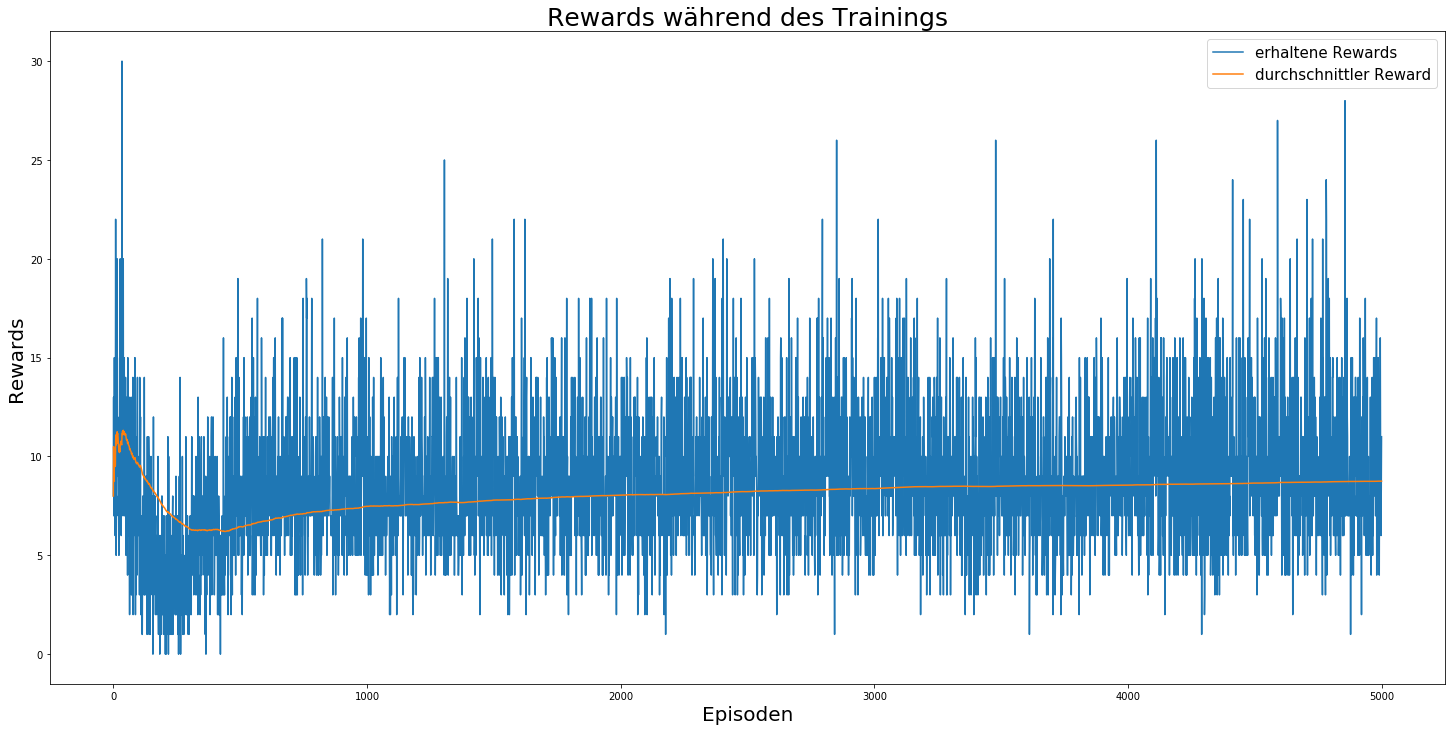

In [38]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# **Trainierten Agenten spielen lassen**

In [26]:
!ls "WEIGHTS/"

Breakout-v0  MsPacman-v0_DQN_End.h5  MsPacman-v0_DQN_Ep_13838.h5


In [27]:
# Gewichte laden
#WEIGHTS_PATH = "WEIGHTS/Pong-v0_DQN_Ep_14840.h5"
#DQN.load_weights(filepath=WEIGHTS_PATH)

## Rendering a Game

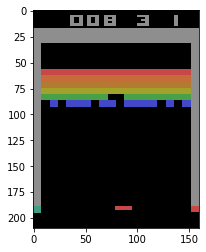

In [ ]:
import gym
from IPython import display
import matplotlib
%matplotlib inline

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(DQN.predict(state))
        state, reward, done, info = env.step(action)